In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import fits
from astropy.io import ascii
from copy import deepcopy

# Observations Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def model_info(source, filt, dist):
    
    model_dir = '/Volumes/NIRData/RDong/'
    fname = 'hd142527_hband.fits'
    
    # Model wavelength
    bp = S.ObsBandpass('h')
    w0 = bp.avgwave() / 1e4

    # Model pixels scale
    model_scale = 0.0091
    
    units = 'mJy/arcsec^2'
    
    # File name, arcsec/pix, dist (pc), wavelength (um), flux units
    args_model = (model_dir+fname, model_scale, dist, w0, units)

    return args_model

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, disk_mod=True, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    fov_pix_orig = fov_pix

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if disk_mod:
            # Convert to photons/sec in specified filter
            args_disk = model_info(sp_sci.name, filt, dist)
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
            data = hdu_disk[0].data
            data -= np.median(data)
            data[data<0] = 0
            data *= 3 # Input model is from a polarized intensity image
            
            # Mask out some regions
            rho = nrc_utils.dist_image(data, center=(258,244))
            data[rho>163] = 0
            rho = nrc_utils.dist_image(data, center=(260,234))
            data[rho<60] = 0
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)
        
        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        if fov_pix is None:
            if mask is None:
                fov_pix = subsize = 400
            elif ('MASK210R' in mask) or ('MASKSWB' in mask):
                fov_pix = subsize = 640
            else:
                fov_pix = subsize = 320
        else:
            subsize = fov_pix
            
        module = 'B' if mask is None else 'A'
            
        #fov_pix = subsize = 320 if fov_pix is None else fov_pix
        oversample = 2
        
        # Offset for bar mask
        if (mask is not None) and ('WB' in mask):
            from pynrc.speckle_noise import offset_bar
            offset_r, offset_theta = offset_bar(filt, mask)
        else:
            offset_r = None
            offset_theta = None
            

        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, module=module,
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                               offset_r=offset_r, offset_theta=offset_theta,
                                               verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

## Functions to init, optimize, and plot

In [6]:
# Generate initial observations for each filter(no WFE drift)
def do_init(disk_mod=True, fov_pix=None, verbose=True):
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       disk_mod=disk_mod, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [7]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [8]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None, exclude_disk=True, exclude_planets=True):
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_drift in wfe_list:
            obs.wfe_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, 
                                       exclude_disk=exclude_disk, exclude_planets=exclude_planets)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [9]:
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes.flatten()):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [10]:
def do_gen_hdus(obs_dict, wfe_drift, verbose=False, **kwargs):
    
    """
    kwargs to pass to gen_roll_image() and their defaults:
    
    PA1 = 0
    PA2 = 10
    zfact         = None
    oversample    = None
    exclude_disk  = False
    exclude_noise = False
    opt_diff      = True
    """
    
    hdulist_dict = {}
    for key in filt_keys:
        if verbose: print(key)
        obs = obs_dict[key]
        obs.wfe_drift = wfe_drift
        hdulist = obs.gen_roll_image(**kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

# Define Sources and their Reference Counterparts

In [11]:
# K-Band Filter
# 2MASS Bandpass
tbl = ascii.read("2mass_ks.txt", names=['Wave', 'Throughput'])
bp_k = S.ArrayBandpass(tbl['Wave']*1e4, tbl['Throughput'], name='Ks')

outdir  = '/Volumes/NIRData/'

In [12]:
#                source,     dist, age, sptype, kmag
args_sources = [('HD142527', 156, 1.0, 'F6III', 5.2)]

# Corresponding reference stars
ref_sources =  [('HD145158', 'F6V', 5.47),
                ('HD142695', 'K1III', 4.987)]

In [13]:
i=0

name_sci, dist_sci, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='bosz')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='bosz')
sp_sci.name = name_sci
sp_ref.name = name_ref

In [14]:
i=1

name_ref2, spt_ref2, kmag_ref2 = ref_sources[i]

# Science target and reference star spectra
#sp_sci = pynrc.stellar_spectrum(spt_sci2, kmag_sci, 'vegamag', bp_k, catname='bosz')
sp_ref2 = pynrc.stellar_spectrum(spt_ref2, kmag_ref2, 'vegamag', bp_k, catname='bosz')
#sp_sci.name = name_sci
sp_ref2.name = name_ref2

In [15]:
bp1 = nrc_utils.read_filter('F356W')
bp2 = nrc_utils.read_filter('F444W')

obs_test1 = S.Observation(sp_sci, bp1, binset=bp1.wave)
obs_test2 = S.Observation(sp_sci, bp2, binset=bp1.wave)
print(obs_test1.effstim('vegamag'), obs_test2.effstim('vegamag'))

obs_test1 = S.Observation(sp_ref, bp1, binset=bp1.wave)
obs_test2 = S.Observation(sp_ref, bp2, binset=bp1.wave)
print(obs_test1.effstim('vegamag'), obs_test2.effstim('vegamag'))
# 5.64, 5.3

obs_test1 = S.Observation(sp_ref2, bp1, binset=bp1.wave)
obs_test2 = S.Observation(sp_ref2, bp2, binset=bp1.wave)
print(obs_test1.effstim('vegamag'), obs_test2.effstim('vegamag'))
# 4.94, 4.78

5.1915267714 5.18878812186
5.46417464006 5.46490880078
4.94077298193 5.00495871355


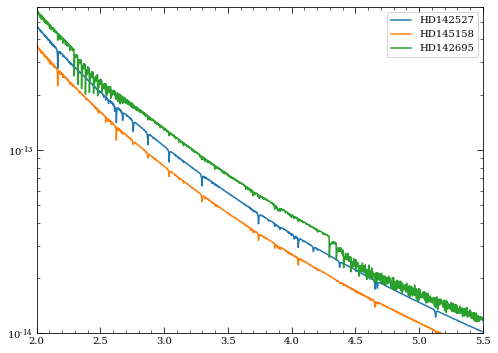

In [16]:
plt.semilogy(sp_sci.wave/1e4, sp_sci.flux, label=name_sci)
plt.semilogy(sp_ref.wave/1e4, sp_ref.flux, label=name_ref)
plt.plot(sp_ref2.wave/1e4, sp_ref2.flux, label=name_ref2)
plt.xlim([2,5.5])
plt.ylim([1e-14,6e-13])

plt.legend()

## Direct Imaging

In [17]:
# List of filters
args_list = [('F187N', None, None),
             ('F210M', None, None),
             ('F356W', None, None),
             ('F444W', None, None)]

filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [18]:
# Create the four individual observations
obs_dict = do_init(disk_mod=True, fov_pix=None, verbose=True)

F187N None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F210M None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F356W None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [19]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,350,350)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,18,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(obs.multiaccum_times)

{u't_exp': 2898.42, u't_acq': 3485.3139999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}
{u't_exp': 2898.42, u't_acq': 3485.3139999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}
{u't_exp': 2898.42, u't_acq': 3485.3139999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}
{u't_exp': 2898.42, u't_acq': 3485.3139999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}


In [20]:
# Add planets and M-Dwarf companion
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(1.48, -80), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=25)
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(1.29, -36), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=25)
    obs.add_planet(mass=5, age=age, entropy=13, rtheta=(0.62,-125), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=5)
    obs.add_planet(mass=4, age=age, entropy=13, rtheta=(0.50, 180), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=5)
    obs.add_planet(sptype='M9V', rtheta=(0.09,90), runits='arcsec', renorm_args=(9.9, 'vegamag', bp_k))

In [21]:
obs_direct = obs_dict
filt_keys_direct = filt_keys

In [22]:
# Create HDU images for each observation
wfe_drift = 5
hdu_direct = do_gen_hdus(obs_direct, wfe_drift, verbose=True, opt_diff=False, PA1=290, PA2=None)

F187N_none_none
F210M_none_none
F356W_none_none
F444W_none_none


In [23]:
# Determine contrast curves for various WFE drift values
wfe_list = [5,10]
nsig = 5
roll = 0
curves_dict = do_contrast(wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll)

# Only want F444W
curves_direct = curves_dict[filt_keys[-1]]

F444W_none_none


## Circular Lyot

In [29]:
# List of filters
args_list = [('F187N', 'MASK210R', 'CIRCLYOT'),
             ('F210M', 'MASK210R', 'CIRCLYOT'),
             ('F356W', 'MASK430R', 'CIRCLYOT'),
             ('F444W', 'MASK430R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [30]:
# Create the four individual observations
obs_dict = do_init(disk_mod=True, fov_pix=None, verbose=True)

F187N MASK210R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F210M MASK210R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F356W MASK430R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASK430R CIRCLYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [31]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,250,250)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,18,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(obs.multiaccum_times)

{u't_exp': 1506.9024, u't_acq': 1582.5995999999998, u't_int_tot': 87.92219999999999, u't_frame': 4.18584, u't_group': 8.37168, u't_int': 83.71679999999999}
{u't_exp': 1506.9024, u't_acq': 1582.5995999999998, u't_int_tot': 87.92219999999999, u't_frame': 4.18584, u't_group': 8.37168, u't_int': 83.71679999999999}
{u't_exp': 1571.4887999999999, u't_acq': 1587.8231999999998, u't_int_tot': 105.85488, u't_frame': 1.06904, u't_group': 10.6904, u't_int': 104.76592}
{u't_exp': 1571.4887999999999, u't_acq': 1587.8231999999998, u't_int_tot': 105.85488, u't_frame': 1.06904, u't_group': 10.6904, u't_int': 104.76592}


In [32]:
# Add planets and M-Dwarf companion
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(1.48, -80), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=25)
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(1.29, -36), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=25)
    obs.add_planet(mass=5, age=age, entropy=13, rtheta=(0.62,-125), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=5)
    obs.add_planet(mass=4, age=age, entropy=13, rtheta=(0.50, 180), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=5)
    obs.add_planet(sptype='M9V', rtheta=(0.09,90), runits='arcsec', renorm_args=(9.9, 'vegamag', bp_k))

In [33]:
# Save observations to separate variable name
obs_circ = obs_dict
filt_keys_circ = filt_keys

In [34]:
# Create HDU images for each observation
wfe_drift = 5
hdu_circ = do_gen_hdus(obs_circ, wfe_drift, verbose=True, opt_diff=False, PA1=290, PA2=300)

F187N_MASK210R_CIRCLYOT
F210M_MASK210R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [35]:
# Determine contrast curves for various WFE drift values
wfe_list = [5,10]
nsig = 5
roll = 10
curves_dict = do_contrast(wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll)

# Only want F444W
curves_circ = curves_dict[filt_keys[-1]]

F444W_MASK430R_CIRCLYOT


## Wedge Lyot

In [36]:
# List of filters
args_list = [('F187N', 'MASKSWB', 'WEDGELYOT'),
             ('F210M', 'MASKSWB', 'WEDGELYOT'),
             ('F356W', 'MASKLWB', 'WEDGELYOT'),
             ('F444W', 'MASKLWB', 'WEDGELYOT')]

filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [37]:
# Create the four individual observations
obs_dict = do_init(disk_mod=True, fov_pix=None, verbose=True)

F187N MASKSWB WEDGELYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F210M MASKSWB WEDGELYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F356W MASKLWB WEDGELYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W MASKLWB WEDGELYOT
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [38]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,250,250)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,18,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(obs.multiaccum_times)

{u't_exp': 1506.9024, u't_acq': 1582.5995999999998, u't_int_tot': 87.92219999999999, u't_frame': 4.18584, u't_group': 8.37168, u't_int': 83.71679999999999}
{u't_exp': 1506.9024, u't_acq': 1582.5995999999998, u't_int_tot': 87.92219999999999, u't_frame': 4.18584, u't_group': 8.37168, u't_int': 83.71679999999999}
{u't_exp': 1571.4887999999999, u't_acq': 1587.8231999999998, u't_int_tot': 105.85488, u't_frame': 1.06904, u't_group': 10.6904, u't_int': 104.76592}
{u't_exp': 1571.4887999999999, u't_acq': 1587.8231999999998, u't_int_tot': 105.85488, u't_frame': 1.06904, u't_group': 10.6904, u't_int': 104.76592}


In [39]:
# Add planets and M-Dwarf companion
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(1.48, -80), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=25)
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(1.29, -36), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=25)
    obs.add_planet(mass=5, age=age, entropy=13, rtheta=(0.62,-125), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=5)
    obs.add_planet(mass=4, age=age, entropy=13, rtheta=(0.50, 180), runits='arcsec', 
                   accr=True, mdot=1e-6, Av=5)
    obs.add_planet(sptype='M9V', rtheta=(0.09,90), runits='arcsec', renorm_args=(9.9, 'vegamag', bp_k))

In [40]:
# Save observations to separate variable name
obs_bar = obs_dict
filt_keys_bar = filt_keys

In [41]:
# Create HDU images for each observation
wfe_drift = 5
hdu_bar = do_gen_hdus(obs_bar, wfe_drift, verbose=True, opt_diff=False, PA1=290, PA2=300)

F187N_MASKSWB_WEDGELYOT
F210M_MASKSWB_WEDGELYOT
F356W_MASKLWB_WEDGELYOT
F444W_MASKLWB_WEDGELYOT


In [42]:
# Determine contrast curves for various WFE drift values
wfe_list = [5,10]
nsig = 5
roll = 10
curves_dict = do_contrast(wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll)

# Only want F444W
curves_bar = curves_dict[filt_keys[-1]]

F444W_MASKLWB_WEDGELYOT


# Contrast Curves

In [50]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None, return_ax=False):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = plt.subplots()
    if colors is None:
        lin_vals = np.linspace(0.2,0.7,len(wfe_list))
        colors = plt.cm.Blues_r(lin_vals)[::-1]
    for j, wfe_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label='$\Delta$' + "WFE = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)
        
    if return_ax: return ax


def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25], **kwargs):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s', **kwargs)
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25], **kwargs):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    #lin_vals = np.linspace(0,0.5,4)
    #cols = plt.cm.Purples_r(lin_vals)[::-1]
    
    dist = obs.distance
    
    if entropy<8: entropy=8
    if entropy>13: entropy=13

    pmag = planet_mags(obs, age, entropy, mass_list, av_vals, **kwargs)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, "Warm")
    ent_str = entropy_string + ' Start'
    #ent_str = '{} Start'.format(entropy_string)

    av_str = '$A_V = [{:.0f},{:.0f}]$'.format(av_vals[0],av_vals[1])
    age_str = 'Age = {:.0f} Myr; '.format(age)
    dist_str = 'Dist = {:.1f} pc; '.format(dist) if dist is not None else ''
    #dist_str=""

    ax.set_title('{} -- {} ({}{}{})'.format(obs.filter,ent_str,age_str,dist_str,av_str))


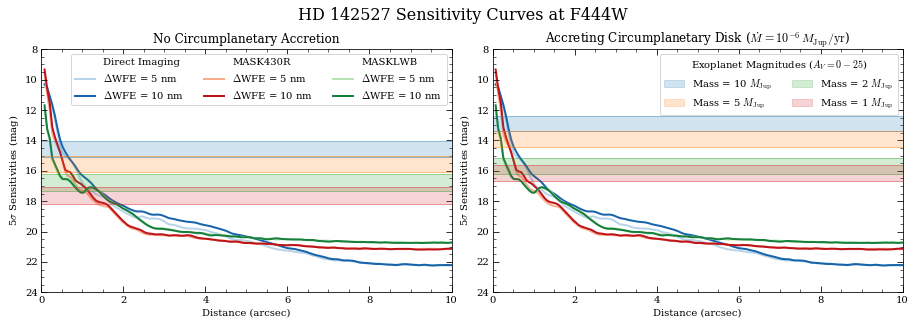

In [52]:
# Plot the contrast curves along with saturation regions
xlim=[0,10]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
ax1, ax2 = axes
entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#label = 'Saturation'
#if rmax1>0:
#    rect1 = patches.Rectangle((0,ylim[0]), rmax1, ylim[1]-ylim[0], alpha=0.5,
#                              color='grey', label=label, zorder=2)
#    ax1.add_patch(rect1)
#if rmax2>0:
#    rect2 = patches.Rectangle((0,ylim[0]), rmax2, ylim[1]-ylim[0], alpha=0.5,
#                              color='grey', label=label, zorder=2)
#    ax2.add_patch(rect2)

nwfe = len(wfe_list)
lin_vals = np.linspace(0.2,0.7,nwfe)

for ax in [ax1, ax2]:
    plot_contrasts(curves_direct, wfe_list, ax=ax)
    plot_contrasts(curves_circ, wfe_list, ax=ax, colors=plt.cm.Reds_r(lin_vals)[::-1])
    plot_contrasts(curves_bar,  wfe_list, ax=ax, colors=plt.cm.Greens_r(lin_vals)[::-1])

obs = obs_direct['F444W_none_none']
plot_planet_patches(ax1, obs, age=age, entropy=13, av_vals=[0,25], accr=False, mdot=1e-6)
plot_planet_patches(ax2, obs, age=age, entropy=13, av_vals=[0,25], accr=True, mdot=1e-6)

#plot_planet_patches(ax2, obs_circ[obs_circ.keys()[-1]], age=age, entropy=13, av_vals=[0,25])

import matplotlib.patches as mpatches
handles, labels = ax2.get_legend_handles_labels()
h1 = handles[0:nwfe]
h2 = handles[nwfe:2*nwfe]
h3 = handles[2*nwfe:3*nwfe]
h1_t = [mpatches.Patch(color='none', label='Direct Imaging')]
h2_t = [mpatches.Patch(color='none', label='MASK430R')]
h3_t = [mpatches.Patch(color='none', label='MASKLWB')]
handles_new = h1_t + h1 + h2_t + h2 + h3_t + h3

ax1.legend(ncol=3, handles=handles_new)

handles, labels = ax1.get_legend_handles_labels()
h3 = handles[3*nwfe:]
ax2.legend(ncol=2, handles=h3, loc=1, title='Exoplanet Magnitudes ($A_V = 0-25$)')


for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}$\sigma$ Sensitivities (mag)'.format(nsig))
    
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])


ax1.set_title('No Circumplanetary Accretion')
ax2.set_title('Accreting Circumplanetary Disk ($\.M = 10^{-6} \/ M_{\mathrm{Jup}}/\mathrm{yr}$)')
#ax1.set_title('')

fig.tight_layout()

#roll_val = 0 if 'none' in filt_keys[0] else 10
#rstr = '{:.0f}'.format(roll_val)
#roll_str = "$"+rstr+"^{\circ}$"
#fig.suptitle('{} (Roll Angle = {})'.format(name_sci,roll_str), fontsize=16);
fig.suptitle('HD 142527 Sensitivity Curves at F444W', fontsize=16)
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)


fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

fname = "{}_contrast.png".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)


# Images

In [55]:
def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, 
                show_sat=False, save_fig=False, well_frac=0.8, 
                return_fig_ax=False, **kwargs):
    
    nfilt = len(filt_keys)
    ext_name = ['Disk Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nim, nfilt, figsize=(10,8))
    axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        header = hdu_sim_r2[0].header
        rho = nrc_utils.dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)
        
        # Scale value for data
        mask_good = data_mod>(0.5*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])
        
        # Scale value for r^2 version
        mask_good = data_mod_r2>(0.5*vmax2)
        scl2 = np.median(hdu_sim_r2[0].data[mask_good] / data_mod_r2[mask_good])
        
        #Saturation mask
        if show_sat:
            well_level = obs.saturation_levels(**kwargs)
            sat_mask = well_level < well_frac
            # Expand the saturation mask by 1 pixel in 
            for dx in [-1,1]: sat_mask = sat_mask & nrc_utils.fshift(sat_mask, dx, 0)
            for dy in [-1,1]: sat_mask = sat_mask & nrc_utils.fshift(sat_mask, 0, dy)
            im_sat = np.ma.masked_where(sat_mask==1, sat_mask)

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = nrc_utils.dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)
            if (i>0) and show_sat: 
                ax.imshow(im_sat, cmap='autumn', alpha=0.75, extent=extent)

            ax.set_aspect('equal')
            if j > 0: ax.set_yticklabels([])
            if i < nim-1: ax.set_xticklabels([])
            if i==nim-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_ylabel(ext_name[i])

            if i==0: ax.set_title(obs.filter)

            if fov>2*rad:
                xlim = [-rad,rad]
                ylim = [-rad,rad]
            else:
                xlim = [-fov/2,fov/2]
                ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            
    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    if obs.mask is not None:
        texp = round(2*texp/100)*100
    else:
        texp = round(texp/100)*100
    exp_text = "t_exp = {:.0f} sec".format(texp)
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)
        
    if return_fig_ax:
        return (fig,axes)

In [83]:
def axes_update(axes, loc, obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, 
                show_sat=False, well_frac=0.8, **kwargs):

    nfilt = len(filt_keys)
    ext_name = ['Disk Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    #fig, axes = plt.subplots(nim, nfilt, figsize=(10,8))
    #axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        vmax  = np.max(data_mod)
        
        # Scale value for data
        mask_good = data_mod>(0.5*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])
        vmax_mod = vmax * scl1
                
        #Saturation mask
        if show_sat:
            well_level = obs.saturation_levels(**kwargs)
            sat_mask = well_level < well_frac
            # Expand the saturation mask by 1 pixel in 
            for dx in [-1,1]: sat_mask = sat_mask & nrc_utils.fshift(sat_mask, dx, 0)
            for dy in [-1,1]: sat_mask = sat_mask & nrc_utils.fshift(sat_mask, 0, dy)
            im_sat = np.ma.masked_where(sat_mask==1, sat_mask)
        
        ax = axes[loc[j]]
        
        data = hdu_sim[0].data
        header = hdu_sim[0].header

        pixscale = header['PIXELSCL']
        rho = nrc_utils.dist_image(data, pixscale=pixscale)

        rad = data.shape[0] * pixscale / 2
        extent = [-rad, rad, -rad, rad]

        ax.imshow(data, vmin=0, vmax=0.8*vmax_mod, extent=extent)
        if show_sat: 
            ax.imshow(im_sat, cmap='autumn', alpha=0.75, extent=extent)

        if fov>2*rad:
            xlim = [-rad,rad]
            ylim = [-rad,rad]
        else:
            xlim = [-fov/2,fov/2]
            ylim = [-fov/2,fov/2]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
        ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

        ax.tick_params(axis='both', color='white', which='both')
        for k in ax.spines.keys():
            ax.spines[k].set_color('white')

            

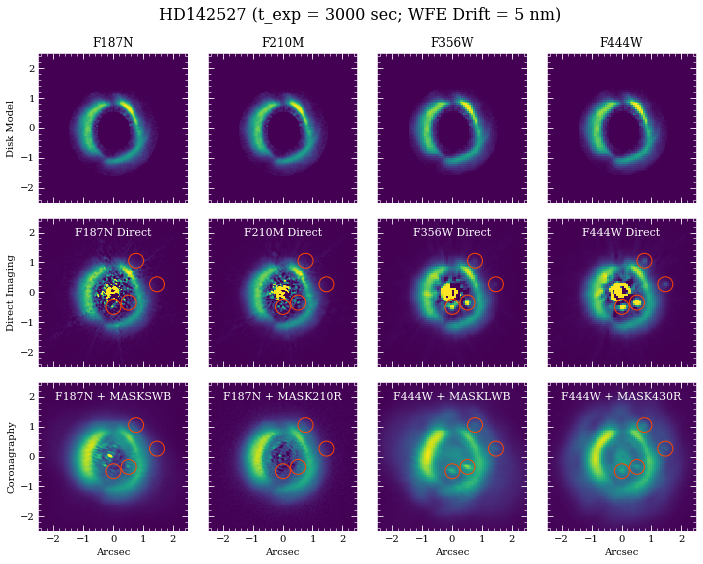

In [105]:
fig, axes = plot_images(obs_direct, hdu_direct, filt_keys_direct, 
            wfe_drift, fov=5, save_fig=False, show_sat=False, well_frac=1, return_fig_ax=True)

fk = [filt_keys_circ[i] for i in [0,-1]]
loc = [(1,2),(3,2)]
axes_update(axes, loc, obs_circ, hdu_circ, fk, 
            wfe_drift, fov=5, show_sat=False, well_frac=1)

fk = [filt_keys_bar[i] for i in [1,-1]]
loc = [(0,2),(2,2)]
axes_update(axes, loc, obs_bar, hdu_bar, fk, 
            wfe_drift, fov=5, show_sat=False, well_frac=1)


axes[0,1].set_ylabel('Direct Imaging')
axes[0,2].set_ylabel('Coronagraphy')

axes[0,1].text(0.5, 0.9, 'F187N Direct',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[0,1].transAxes,
        color='white', fontsize=11)
axes[1,1].text(0.5, 0.9, 'F210M Direct',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[1,1].transAxes,
        color='white', fontsize=11)
axes[2,1].text(0.5, 0.9, 'F356W Direct',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[2,1].transAxes,
        color='white', fontsize=11)
axes[3,1].text(0.5, 0.9, 'F444W Direct',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[3,1].transAxes,
        color='white', fontsize=11)

axes[0,2].text(0.5, 0.9, 'F187N + MASKSWB',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[0,2].transAxes,
        color='white', fontsize=11)
axes[1,2].text(0.5, 0.9, 'F187N + MASK210R',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[1,2].transAxes,
        color='white', fontsize=11)
axes[2,2].text(0.5, 0.9, 'F444W + MASKLWB',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[2,2].transAxes,
        color='white', fontsize=11)
axes[3,2].text(0.5, 0.9, 'F444W + MASK430R',
        verticalalignment='center', horizontalalignment='center',
        transform=axes[3,2].transAxes,
        color='white', fontsize=11)


rt_vals = [(1.48, -80), (1.29, -36), (0.62,-125), (0.50, 180)]
axsub = axes[:,1:]
for r,t in rt_vals:
    x,y = nrc_utils.rtheta_to_xy(r,t)
    x+=0.01
    y+=0.01
    for ax in axsub.flatten():
        circle = matplotlib.patches.Circle((x,y), radius=0.25, lw=1, edgecolor='orangered', facecolor='none')
        ax.add_artist(circle);

exp_text = "t_exp = {:.0f} sec".format(3000)
wfe_text = "WFE Drift = {} nm".format(wfe_drift)
fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);

fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

fname = "{}_images.png".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)



In [114]:
# Background Sensitivities
for k in filt_keys_direct:
    print(k)
    obs = obs_direct[k]
    print(obs.sensitivity(nsig=5, units='vegamag'))

F187N_none_none
({u'units': 'vegamag', u'sensitivity': 21.41326451425987, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'}, {u'units': u'vegamag/arcsec^2', u'sensitivity': 17.769601269173997, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'})
F210M_none_none
({u'units': 'vegamag', u'sensitivity': 23.524163450241005, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'}, {u'units': u'vegamag/arcsec^2', u'sensitivity': 19.938362717663495, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'})
F356W_none_none
({u'units': 'vegamag', u'sensitivity': 23.73947671713732, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'}, {u'units': u'vegamag/arcsec^2', u'sensitivity': 21.51400804251388, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'})
F444W_none_none
({u'units': 'vegamag', u'sensitivity': 23.31045834017815, u'nsig': 5, u'Spectrum': u'Flat spectrum in photlam'}, {u'units': u'vegamag/arcsec^2', u'sensitivity': 21.248654309515825, u'nsig': 5, u'Spectrum': u'Flat spectrum in pho